# Football Betting using FiveThirtyEight's Soccer Power Index
## Goal
Backtest a strategy of using the FiveThirtyEight's Soccer Power Index for betting.

## Imports

In [51]:
import concurrent.futures
import io
import json
import os

from thefuzz import fuzz
import missingno as msno
import networkx as nx
import numpy as np
import pandas as pd
import requests

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")


## FiveThirtyEight
Download Soccer Power Index dataset.

In [52]:
SPI_SOCCER_URL = "https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv"

content = requests.get(SPI_SOCCER_URL).content
df_spi = pd.read_csv(io.StringIO(content.decode()))
df_spi["date"] = pd.to_datetime(df_spi["date"], format="%Y-%m-%d")

df_spi.sample(5)


,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
61008,2022,2022-11-10,2105,Brasileiro Série A,Botafogo,Santos,49.68,53.29,0.3733,0.3333,...,0.0,0.0,3.0,0.0,2.11,0.33,0.63,0.71,3.15,0.00
33018,2019,2020-07-22,1879,Swiss Raiffeisen Super League,Thun,Servette,34.05,48.96,0.2763,0.4688,...,34.7,0.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
25340,2019,2019-09-27,1952,Mexican Primera Division Torneo Apertura,Puebla,León,38.73,53.59,0.3043,0.4366,...,6.5,9.3,2.0,1.0,1.65,0.28,0.68,0.71,2.10,1.05
56974,2022,2022-08-14,1837,Danish SAS-Ligaen,Viborg,Silkeborg,36.94,47.39,0.3109,0.4358,...,17.1,50.5,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
53784,2022,2022-04-15,2160,United Soccer League,New York Red Bulls II,Rio Grande Valley FC Toros,5.97,15.90,0.2472,0.4932,...,7.6,18.2,0.0,1.0,0.50,1.11,0.75,0.48,0.00,1.05


Earliest season.

In [53]:
df_spi["season"].min()


2016

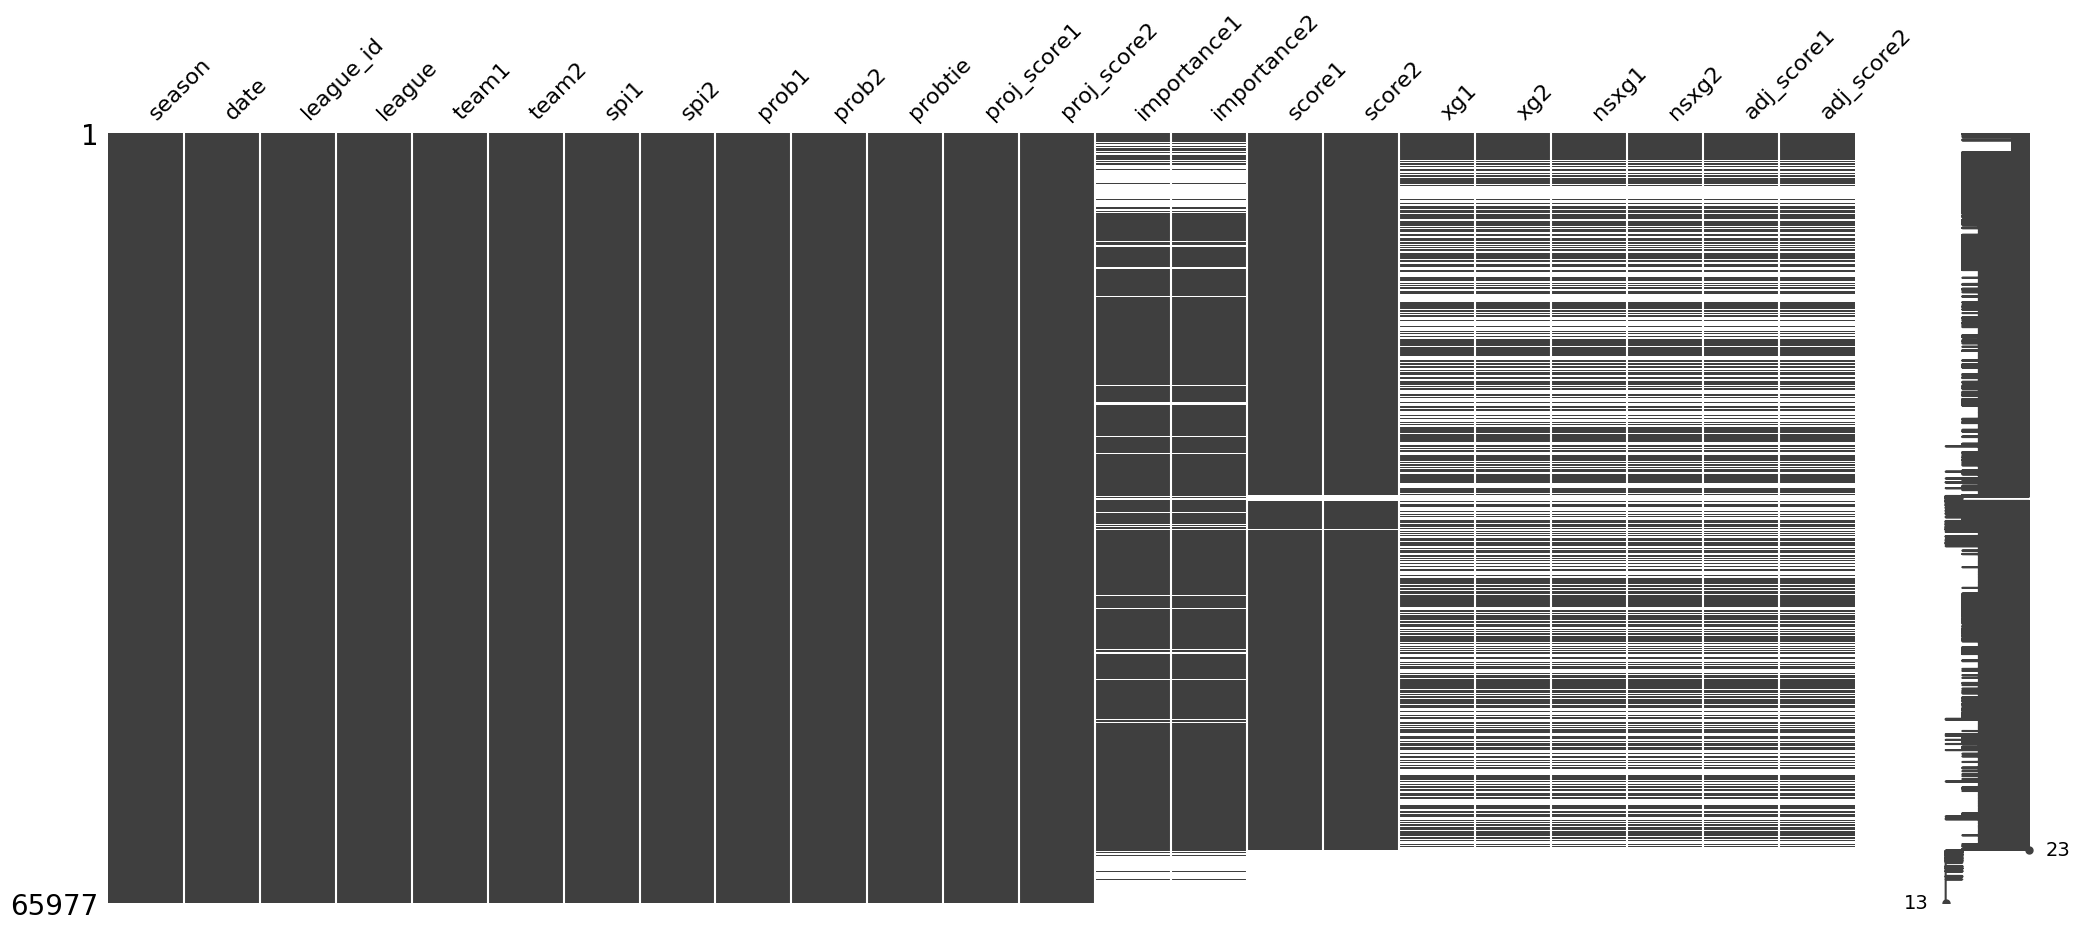

In [54]:
msno.matrix(df_spi.sort_values("date"));

## Football-Data.co.uk
[football-data.co.uk](https://www.football-data.co.uk) is a website that provides historical betting odds for many soccer leagues.

In [55]:
FOOTBALL_DATA_URL = "https://www.football-data.co.uk/mmz4281/{season}/{league}.csv"
LEAGUES = {
    "E0": "Barclays Premier League",
    "E1": "English League Championship",
    "E2": "English League One",
    "E3": "English League Two",
    "SC0": "Scottish Premiership",
    "D1": "German Bundesliga",
    "D2": "German 2. Bundesliga",
    "I1": "Italy Serie A",
    "I2": "Italy Serie B",
    "SP1": "Spanish Primera Division",
    "SP2": "Spanish Segunda Division",
    "F1": "French Ligue 1",
    "F2": "French Ligue 2",
    "N1": "Dutch Eredivisie",
    "B1": "Belgian Jupiler League",
    "P1": "Portuguese Liga",
    "T1": "Turkish Turkcell Super Lig",
    "G1": "Greek Super League",
}


def get_football_data(year, league):
    """Get football data."""
    season = str(year - 1)[-2:] + str(year)[-2:]
    url = FOOTBALL_DATA_URL.format(season=season, league=league)
    content = requests.get(url).content
    data = pd.read_csv(io.StringIO(content.decode(encoding="latin1")))
    data = data.dropna(how="all")
    data["Season"] = season
    data["url"] = url
    return data


with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(get_football_data, year=year, league=league)
        for league in LEAGUES.keys()
        for year in range(2023, 2015, -1)
    ]
    results = [future.result() for future in concurrent.futures.as_completed(futures)]

df_bet = pd.concat(results)
df_bet.sample(5)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,HFKC,AFKC,Unnamed: 105
51,SP1,17/09/2022,13:00,Mallorca,Almeria,1.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,E3,12/10/2019,15:00,Exeter,Forest Green,1.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,D2,13/06/2020,12:00,Osnabruck,Bochum,0.0,2.0,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,D1,22/12/2018,NaN,RB Leipzig,Werder Bremen,3.0,2.0,H,2.0,0.0,...,2.35,2.28,1.70,1.65,NaN,NaN,NaN,NaN,NaN,NaN
136,B1,09/12/16,NaN,Lokeren,Waregem,1.0,1.0,D,0.0,1.0,...,1.99,1.86,2.04,1.97,2.6,3.2,2.75,NaN,NaN,NaN


Dates comes in differents formats depending on the year.

In [56]:
date1 = pd.to_datetime(df_bet["Date"], format="%d/%m/%Y", errors="coerce")
date2 = pd.to_datetime(df_bet["Date"], format="%d/%m/%y", errors="coerce")
df_bet["Date"] = date1.fillna(date2)

df_bet.sample(5)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,HFKC,AFKC,Unnamed: 105
211,SP2,2019-12-14,17:00,Ponferradina,La Coruna,2.0,0.0,H,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,E1,2021-01-20,19:00,Nott'm Forest,Middlesbrough,1.0,2.0,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,N1,2020-11-21,17:45,Willem II,VVV Venlo,2.0,1.0,H,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,E0,2021-04-05,20:15,Wolves,West Ham,2.0,3.0,A,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,SC0,2016-02-20,NaN,Kilmarnock,Dundee,0.0,0.0,D,0.0,0.0,...,1.88,1.82,2.09,2.01,3.0,3.4,2.3,NaN,NaN,NaN


In [57]:
df_spi = df_spi[df_spi["league"].isin(list(LEAGUES.values()))]

Each data source uses different ways of writing the same clubs names. I will use a dict to make names the same.

In [58]:
# # Generate empty names dict

# frames = [df_spi["team1"], df_spi["team2"], df_bet["HomeTeam"], df_bet["AwayTeam"]]
# names = pd.concat(frames).drop_duplicates()

# pairs = [
#     (name, other_name)
#     for name in names
#     for other_name in names
#     if fuzz.partial_ratio(name, other_name) > 90
# ]

# graph = nx.Graph()
# graph.add_edges_from(pairs)

# clusters = [list(cluster) for cluster in nx.connected_components(graph)]
# clusters = {cluster[0]: cluster for cluster in clusters}
# (
#     pd.Series(clusters)
#     .sort_index()
#     .to_json(os.path.join(DATA_DIR, "names.json"), force_ascii=False)
# )


In [64]:
with open(os.path.join(DATA_DIR, "names.json"), encoding="utf-8") as file:
    names_dict = json.load(file)


names_dict = {
    name.strip(): i.strip()
    for i, name_list in names_dict.items()
    for name in name_list
}


def clean(series, translate_dict):
    """Clean text in pandas series."""
    return (
        series
        .str.strip()
        .apply(lambda x: translate_dict[x] if x in translate_dict else x)
    )


df_spi["team1_clean"] = clean(df_spi["team1"], names_dict)
df_spi["team2_clean"] = clean(df_spi["team2"], names_dict)
df_bet["HomeTeam_clean"] = clean(df_bet["HomeTeam"], names_dict)
df_bet["AwayTeam_clean"] = clean(df_bet["AwayTeam"], names_dict)

spi_teams = set(pd.concat((df_spi["team1_clean"],  df_spi["team2_clean"])))
bet_teams = set(pd.concat((df_bet["HomeTeam_clean"], df_bet["AwayTeam_clean"])))

sym_diff = bet_teams.symmetric_difference(spi_teams)
sorted(sym_diff)


['Adanaspor',
 'Ankaraspor',
 'Athletic Bilbao B',
 'Barnet',
 'Beerschot VA',
 'Buyuksehyr',
 'Chesterfield',
 'Creteil',
 'Dag and Red',
 'Eskisehirspor',
 'Evian Thonon Gaillard',
 'FC Cologne',
 'FC Koln',
 'Fatih Karagümrük',
 'For Sittard',
 'Fortuna Sittard',
 'Frankfurt FSV',
 'Gimnastic',
 'Gimnástic Tarragona',
 'Inverness C',
 'Iraklis',
 'Istanbul Basaksehir',
 'KFCO Beerschot-Wilrijk',
 'Kallonis',
 'Karagumruk',
 'Kerkyra',
 'Latina',
 'Llagostera',
 'Mersin Idman Yurdu',
 'Munich 1860',
 'NEC',
 'Nijmegen',
 'OH Leuven',
 'Orleans',
 'Orléans',
 'Osmanlispor',
 'Oud-Heverlee Leuven',
 'Panthrakikos',
 'Platanias',
 'Quevilly Rouen',
 'RKC',
 'Sp Gijon',
 'Sporting Gijón',
 'St Truiden',
 'St. Gilloise',
 'St. Truidense',
 'UCAM Murcia',
 'US Quevilly',
 'Uniao Madeira',
 'Union Saint Gilloise',
 'Veria',
 'Virtus Lanciano',
 'Waalwijk',
 'York']

There are only a few clubs left that are unmatch. Maybe one dataset has more games than the other.

Now that names are fixed, it is able to be merged.

In [7]:
df_bet = df_bet.rename(
    {"Date": "date", "HomeTeam": "team1", "AwayTeam": "team2"}, axis=1
)

df_bet["date"] = df_bet["date"].dt.date
df_spi["date"] = df_spi["date"].dt.date

# df_bet_minus = df_bet.copy()
# df_bet_minus["date"] = df_bet_minus["date"] - pd.Timedelta(days=1)

# df_bet_plus = df_bet.copy()
# df_bet_plus["date"] = df_bet_plus["date"] + pd.Timedelta(days=1)

# df_bet = df_bet.append(df_bet_minus)
# df_bet = df_bet.append(df_bet_plus)

df = df_spi.merge(df_bet, how="inner", on=["date", "team1", "team2"])

print(df_spi.shape[0] - df.shape[0])


584


Add each results point of view to the dataset.

In [8]:
df["win"] = df["score1"] > df["score2"]
df["draw"] = df["score1"] == df["score2"]
df["loss"] = df["score1"] < df["score2"]

df_inv = df.copy()

df_inv["team2"], df_inv["team1"] = df["team1"], df["team2"]
df_inv["spi2"], df_inv["spi1"] = df["spi1"], df["spi2"]
df_inv["prob2"], df_inv["prob1"] = df["prob1"], df["prob2"]
df_inv["proj_score2"], df_inv["proj_score1"] = df["proj_score1"], df["proj_score2"]
df_inv["importance2"], df_inv["importance1"] = df["importance1"], df["importance2"]
df_inv["score2"], df_inv["score1"] = df["score1"], df["score2"]
df_inv["xg2"], df_inv["xg1"] = df["xg1"], df["xg2"]
df_inv["nsxg2"], df_inv["nsxg1"] = df["nsxg1"], df["nsxg2"]
df_inv["adj_score2"], df_inv["adj_score1"] = df["adj_score1"], df["adj_score2"]
df_inv["B365A"], df_inv["B365H"] = df["B365H"], df["B365A"]
df_inv["MaxA"], df_inv["MaxH"] = df["MaxH"], df["MaxA"]
df_inv["AvgA"], df_inv["AvgH"] = df["AvgH"], df["AvgA"]
df_inv["loss"], df_inv["win"] = df["win"], df["loss"]

df_draw = df.copy()
df_draw["team1"] = "draw"
df_draw["team2"] = np.nan
df_draw["prob1"] = df["probtie"]
df_draw["B365H"] = df["B365D"]
df_draw["MaxH"] = df["MaxD"]
df_draw["AvgH"] = df["AvgD"]
df_draw["win"] = df["draw"]

df = df.append(df_inv).reset_index(drop=True)
df = df.append(df_draw).reset_index(drop=True)

print(df.shape)

df.sample(5)


(5088, 150)


,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,win,draw,loss
2363,2018,2019-03-03,2411,Barclays Premier League,chelsea,fulham,84.02,56.99,0.6604,0.1354,...,2.09,2.02,1.90,1.84,NaN,NaN,NaN,True,False,False
2870,2020,2020-10-04,2411,Barclays Premier League,sheffield united,arsenal,66.93,78.69,0.1772,0.5815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
2126,2018,2018-09-22,2411,Barclays Premier League,watford,fulham,69.59,61.89,0.3389,0.3858,...,2.17,2.12,1.82,1.77,NaN,NaN,NaN,False,True,False
4263,2019,2019-11-09,2411,Barclays Premier League,draw,NaN,86.49,70.40,0.1774,0.1056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1143,2020,2020-09-12,2411,Barclays Premier League,west ham,newcastle,70.38,64.72,0.4887,0.2556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True


## Results
### ROI Lines

In [9]:
def roi_lines(data, odds_col):
    """Calculate ROI."""
    data["ev"] = data["prob1"] * (data[odds_col] - 1) - (1 - data["prob1"])
    data["bet"] = data["ev"] > 0
    data["balance"] = data["bet"].astype(int) * (
        data["win"].astype(int) * data[odds_col] - 1
    )

    return data["balance"].sum() / data["bet"].sum()


print(f"Avg ROI = {roi_lines(df, 'AvgH') * 100:.2g}%")
print(f"B365 ROI = {roi_lines(df, 'B365H') * 100:.2g}%")
print(f"Max ROI = {roi_lines(df, 'MaxH') * 100:.2g}%")


Avg ROI = -1.7%
B365 ROI = 2.1%
Max ROI = 3.6%


### ROI Over/Under

In [10]:
df[">2.5"] = df["score1"] + df["score2"] > 2.5
df["<2.5"] = df["score1"] + df["score2"] < 2.5


def roi_over_under(data, odds_col):
    """Calculate ROI."""
    pd.options.mode.chained_assignment = None
    data = data.dropna(subset=[f"{odds_col}<2.5", f"{odds_col}>2.5", "team2"])
    data["bet_over"] = data["x>2.5"].astype(int)
    data["bet_under"] = data["x<2.5"].astype(int)
    data["balance_over"] = data["bet_over"] * (
        data[">2.5"].astype(int) * df[f"{odds_col}>2.5"] - 1
    )
    data["balance_under"] = data["bet_under"] * (
        data["<2.5"].astype(int) * df[f"{odds_col}<2.5"] - 1
    )
    data["balance"] = data["balance_over"] + data["balance_under"]
    return data["balance"].sum() / data["bet"].sum()


df["x>2.5"] = df["proj_score1"] + df["proj_score1"] > 2.5
df["x<2.5"] = df["proj_score1"] + df["proj_score1"] < 2.5

print(f"Avg ROI = {roi_over_under(df, 'Avg') * 100:.2g}%")
print(f"B365 ROI = {roi_over_under(df, 'B365') * 100:.2g}%")
print(f"Max ROI = {roi_over_under(df, 'Max') * 100:.2g}%")


Avg ROI = -7.3%
B365 ROI = -8.1%
Max ROI = -0.29%


## Conclusion
### Lines
This strategy would lose money against the average betting site. However, it is able to have a small margin agains some specific websites that offers good odds.

### Over/Under
The over/under strategy is not profitable, even considering the best odds available.